# Phenogenetic architectures

## Overview

Here's where things start to get interesting. The ability to easily construct and modify phenogenetic architectures with arbitrary complexity was the core motivating feature underlying the development of `xftsim`. In what follows, we introduce the `ArchitectureComponent` and `Architecture` classes that make this possible.


:::{warning}

We highly suggest you be familiar with the `xftsim` indexers and data structures introduce [here](./indexing.ipynb) and [here](./struct.ipynb), respectively.

:::

## ArchitectureComponent objects 

An `Architecture` object largely consists of an iterable collection of `ArchitectureComponents`. These component objects take haplotype and phenotype data as inputs and modify phenotypes by reference. For example, the widely used additive genetic architecture

$$y=X\beta + e,$$
$$e \sim N(0, \sigma^2_e),$$
$$\beta \stackrel{iid}{\sim}N_m(0,\sigma^2_\beta),$$

is represented in `xftsim` as a collection of three components: the additive genetic component $X\beta$, the additive noise component $e$, and the sum transformation $y = X\beta + e$.


In [7]:
import xftsim as xft
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 240 ## better looking plots

demo = xft.sim.DemoSimulation("BGRM")
demo

<DemoSimulation>
Bivariate GCTA with balanced random mating demo

n = 2000; m = 400
Two phenotypes, height and bone mineral denisty (BMD)
assuming bivariate GCTA infinitessimal archtecture
with h2 values set to 0.5 and 0.4 for height and BMD
respectively and a genetic effect correlation of 0.0.

This architecture consists of three components:

In [8]:
len(demo.architecture.components)

3

The genetic component uses haplotype information (but not phenotype information) as inputs and generates the `additiveGenetic` phenotype component as its output:

In [9]:
demo.architecture.components[0]

<class 'xftsim.arch.AdditiveGeneticComponent'>

## INPUTS:
 - haplotypes: True
 - phenotype components:
<Empty ComponentIndex>

## OUTPUTS:
 - phenotype components:
<ComponentIndex>
  1 component of 2 phenotypes spanning 1 generation
                               phenotype_name   component_name  \
component                                                        
height.additiveGenetic.proband         height  additiveGenetic   
BMD.additiveGenetic.proband               BMD  additiveGenetic   

                                vorigin_relative     comp_type  
component                                                       
height.additiveGenetic.proband                -1  intermediate  
BMD.additiveGenetic.proband                   -1  intermediate  

The noise component, on the other hand, doesn't use haplotype information or phenotype information as inputs and generates the `additiveNoise` phenotype component as its output:

In [10]:
demo.architecture.components[1]

<class 'xftsim.arch.AdditiveNoiseComponent'>

## INPUTS:
 - haplotypes: False
 - phenotype components:
<Empty ComponentIndex>

## OUTPUTS:
 - phenotype components:
<ComponentIndex>
  1 component of 2 phenotypes spanning 1 generation
                             phenotype_name component_name  vorigin_relative  \
component                                                                      
height.additiveNoise.proband         height  additiveNoise                -1   
BMD.additiveNoise.proband               BMD  additiveNoise                -1   

                                 comp_type  
component                                   
height.additiveNoise.proband  intermediate  
BMD.additiveNoise.proband     intermediate  

Finally, the sum component ignores haplotype data but uses both the `additiveGenetic` and `additiveNoise` components to compute the `phenotype` component:

In [11]:
demo.architecture.components[2]

<class 'xftsim.arch.SumAllTransformation'>

## INPUTS:
 - haplotypes: False
 - phenotype components:
<ComponentIndex>
  2 components of 2 phenotypes spanning 1 generation
                               phenotype_name   component_name  \
component                                                        
height.additiveGenetic.proband         height  additiveGenetic   
height.additiveNoise.proband           height    additiveNoise   
BMD.additiveGenetic.proband               BMD  additiveGenetic   
BMD.additiveNoise.proband                 BMD    additiveNoise   

                                vorigin_relative     comp_type  
component                                                       
height.additiveGenetic.proband                -1  intermediate  
height.additiveNoise.proband                  -1  intermediate  
BMD.additiveGenetic.proband                   -1  intermediate  
BMD.additiveNoise.proband                     -1  intermediate  

## OUTPUTS:
 - phenotype components:
<Com

## Dependency graphs

All `ArchitectureComponent` and `Architecture` objects include a `draw_dependency_graph()` method for visualizing the dependence between components. This can be helpful for making sure your model is correctly specified. For example, the `SumAllTransformation` above has the following dependency graph:

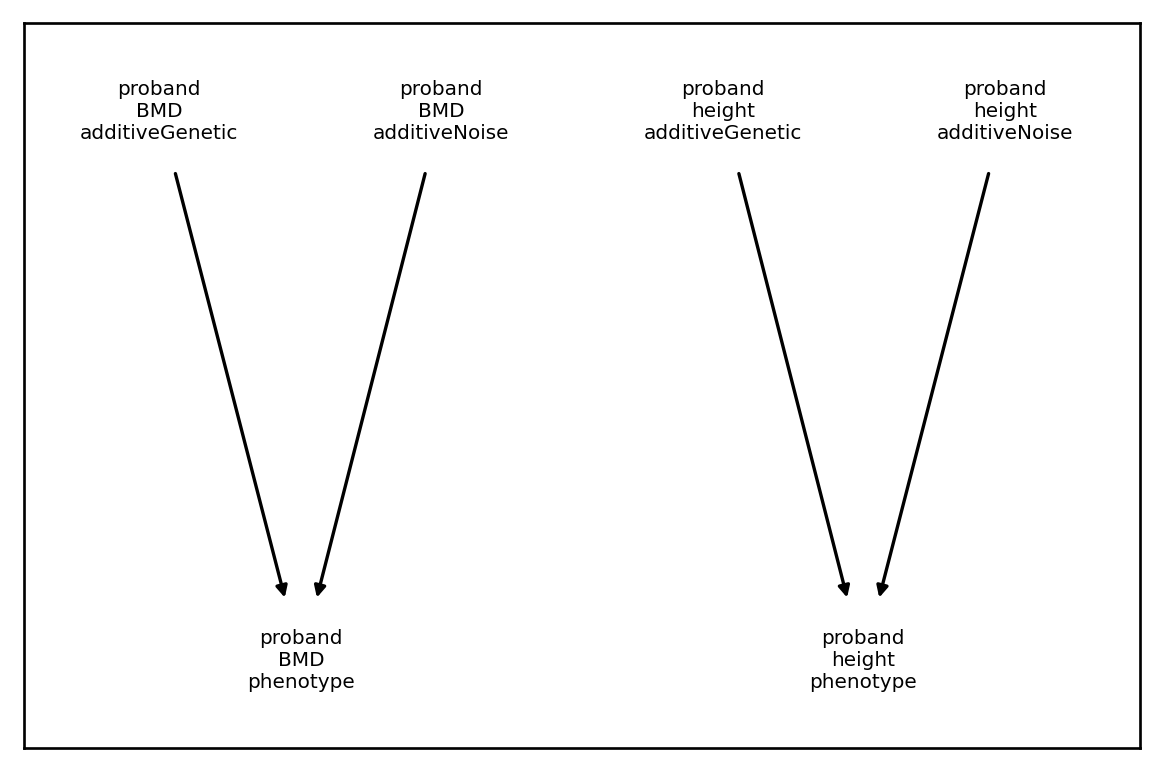

In [12]:
demo.architecture.components[2].draw_dependency_graph()

The `Architecture` object, which includes all three components has the following dependency graph:

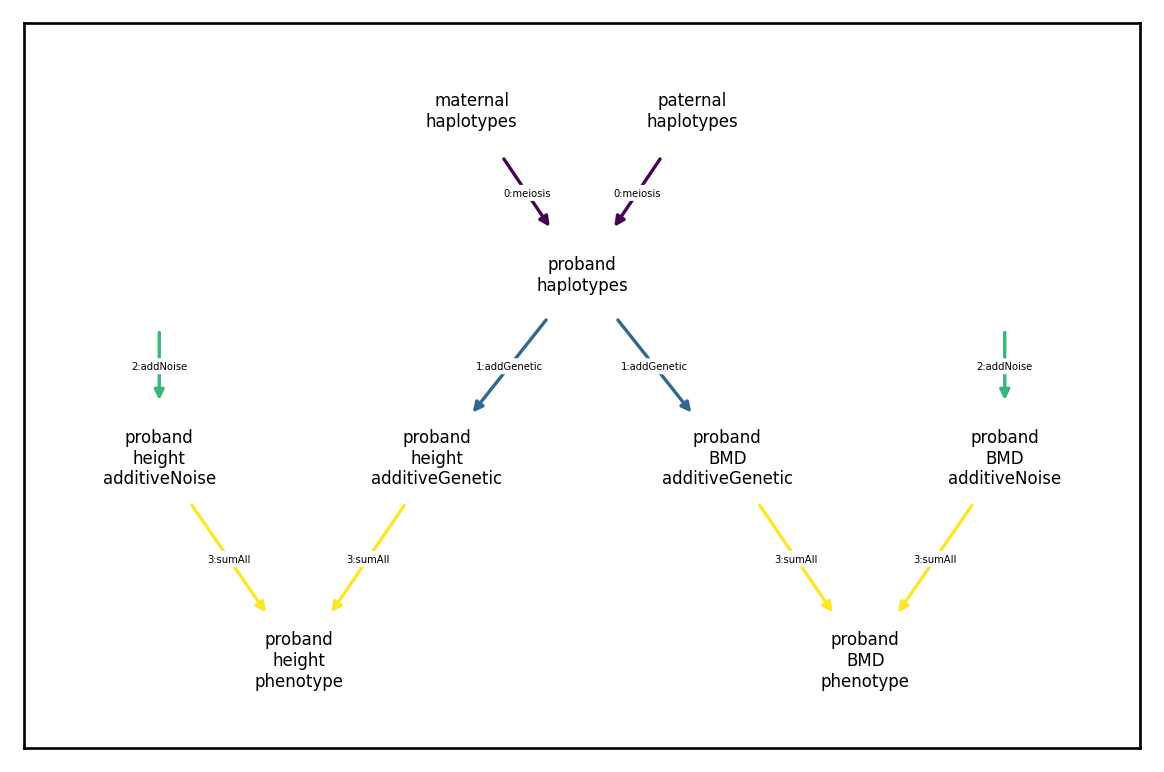

In [13]:
demo.architecture.draw_dependency_graph()

We will go through some commonly used `ArchitectureComponent`s (including the above) in what follows.

## Genetic components

To specify an 'arch.AdditiveGeneticComponent', we need to first create an `effect.AdditiveEffects` object. Additive effects relating $m$ diploid variants to $k$ phenotypic components are comprised of an $m\times k$ matrix of effects, an index of the $m$ variants (can be `xft.index.HaploidVariantIndex` or `xft.index.DiploidVariantIndex`), and an index of the $k$ components in the form of an `xft.index.ComponentIndex`. 

For example, we can create effects under the additive model specified above as follows:

In [14]:
import numpy as np

beta = np.random.randn(demo.haplotypes.xft.m, 1) * np.sqrt(.5)
vindex = demo.haplotypes.xft.get_variant_indexer()
cindex = xft.index.ComponentIndex.from_product('height', 'additiveGenetic')

effects = xft.effect.AdditiveEffects(beta=beta, 
                                     variant_indexer=vindex,
                                     component_indexer=cindex)

Alternatively, we could construct additive components for two phenotypes, height and bone mineral density (BMD), with genetic variances 0.5 and 0.4, respectively, and genetic effect correlation 0.25 as follows: 

In [15]:
m = demo.haplotypes.xft.m
vcov = np.array([[.5, .25*np.sqrt(.5*.4)],
                 [.25*np.sqrt(.5*.4), .4]])


beta = np.random.multivariate_normal(mean = np.zeros(2),
                                     cov = vcov, size = m)
vindex = demo.haplotypes.xft.get_variant_indexer()
cindex = xft.index.ComponentIndex.from_product(('height','BMD'), 'additiveGenetic')

effects = xft.effect.AdditiveEffects(beta=beta, 
                                     variant_indexer=vindex,
                                     component_indexer=cindex)

We can confirm that these effects behave as expected if desired:

In [16]:
correlation_matrix = np.corrcoef(demo.haplotypes.data @ effects.beta_unscaled_unstandardized_haploid, rowvar=-False)
covariance_matrix = np.cov(demo.haplotypes.data @ effects.beta_unscaled_unstandardized_haploid, rowvar=-False)

correlation_matrix, covariance_matrix


(array([[1.        , 0.18591137],
        [0.18591137, 1.        ]]),
 array([[0.46535728, 0.076237  ],
        [0.076237  , 0.36135422]]))

We then pass the `AdditiveEffects` object to the `AdditiveGeneticComponent` constructor to generate the corresponding archetecture component:

<class 'xftsim.arch.AdditiveGeneticComponent'>

## INPUTS:
 - haplotypes: True
 - phenotype components:
<Empty ComponentIndex>

## OUTPUTS:
 - phenotype components:
<ComponentIndex>
  1 component of 2 phenotypes spanning 1 generation
                               phenotype_name   component_name  \
component                                                        
height.additiveGenetic.proband         height  additiveGenetic   
BMD.additiveGenetic.proband               BMD  additiveGenetic   

                                vorigin_relative     comp_type  
component                                                       
height.additiveGenetic.proband                -1  intermediate  
BMD.additiveGenetic.proband                   -1  intermediate  

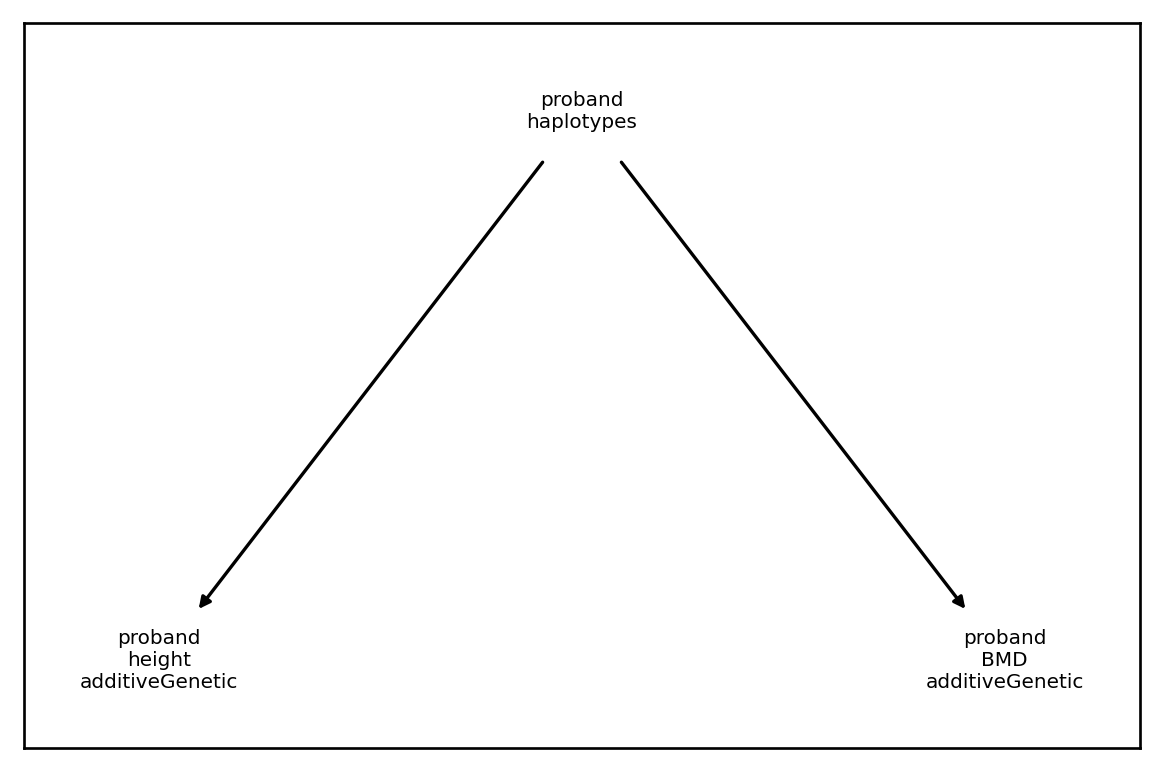

In [17]:
arch = xft.arch.AdditiveGeneticComponent(effects)
arch.draw_dependency_graph()
arch

## Noise components

Noise components are likely the simplest archetectural component to specify. For iid Gaussian noise, we only need to provide variances (or standard deviations if preferred) and the names of the corresponding phenotypes to the `AdditiveNoiseComponent` constructor. Here we construct independent noise components for height and BMD with variances 0.5 and 0.6, respectively:

In [18]:
inoise = xft.arch.AdditiveNoiseComponent(variances=[.5,.6], phenotype_name=['height', 'BMD'])
inoise

<class 'xftsim.arch.AdditiveNoiseComponent'>

## INPUTS:
 - haplotypes: False
 - phenotype components:
<Empty ComponentIndex>

## OUTPUTS:
 - phenotype components:
<ComponentIndex>
  1 component of 2 phenotypes spanning 1 generation
                             phenotype_name component_name  vorigin_relative  \
component                                                                      
height.additiveNoise.proband         height  additiveNoise                -1   
BMD.additiveNoise.proband               BMD  additiveNoise                -1   

                                 comp_type  
component                                   
height.additiveNoise.proband  intermediate  
BMD.additiveNoise.proband     intermediate  

If we want (possibly correlated) multivariate normal noise components, we can use `CorrelatedNoiseComponent` instead. Here we set the correlation between the noise components for height and BMD to 0.3:

In [19]:
vcov = np.array([[.5, .3*np.sqrt(.5*.6)],
                 [.3*np.sqrt(.5*.6), .6]])

cnoise = xft.arch.CorrelatedNoiseComponent(vcov=vcov, phenotype_name=['height', 'BMD'])
cnoise

<class 'xftsim.arch.CorrelatedNoiseComponent'>

## INPUTS:
 - haplotypes: False
 - phenotype components:
<Empty ComponentIndex>

## OUTPUTS:
 - phenotype components:
<ComponentIndex>
  1 component of 2 phenotypes spanning 1 generation
                               phenotype_name   component_name  \
component                                                        
height.correlatedNoise.proband         height  correlatedNoise   
BMD.correlatedNoise.proband               BMD  correlatedNoise   

                                vorigin_relative     comp_type  
component                                                       
height.correlatedNoise.proband                -1  intermediate  
BMD.correlatedNoise.proband                   -1  intermediate  

## Causal dependencies 

### Univariate causal dependence

We use the term "causal dependences" to refer to scenarios where one phenotype component is directly affected by another within an individual. For example, suppose I want to model years of education and income. It may reasonable to assume that regardless whatever individual heritable and/or non-heritable influences on either outcome, years of education will have some possitve effect on income (i.e., advanced degrees increase earnings). 

For simplicity, we will assume that neither trait is heritable, but that 50% of the variance in income is a linear function of years of education (which we treat here as continous for simplicity). I can model this dependence using `LinearTransformationComponent`.

One (very simple) generative model might look like this

$$\text{Edu}_\text{noise}\sim N(0,1)$$
$$\text{Income}_\text{noise}\sim N(0,.5)$$
$$\text{Edu} = \text{Edu}_\text{noise}$$
$$\text{Income}=\text{Income}_\text{noise} +\text{Edu}_\text{noise}\sqrt{.5}$$


First, we'll model the independent parts of our phenotypes. We want education to be completely random so we'll set it's variance to 1.0, whereas the independent noise for income will have variance 0.5:


In [20]:
ncomp = xft.arch.AdditiveNoiseComponent(variances=[1,.5], 
                                        phenotype_name=['edu', 'income'])
ncomp

<class 'xftsim.arch.AdditiveNoiseComponent'>

## INPUTS:
 - haplotypes: False
 - phenotype components:
<Empty ComponentIndex>

## OUTPUTS:
 - phenotype components:
<ComponentIndex>
  1 component of 2 phenotypes spanning 1 generation
                             phenotype_name component_name  vorigin_relative  \
component                                                                      
edu.additiveNoise.proband               edu  additiveNoise                -1   
income.additiveNoise.proband         income  additiveNoise                -1   

                                 comp_type  
component                                   
edu.additiveNoise.proband     intermediate  
income.additiveNoise.proband  intermediate  

Next, we'll add a `LinearTransformationComponent`, which requires the following arguments:
 - `input_cindex`: the ComponentIndex for the independent variable(s)
 - `output_cindex`: the ComponentIndex for the dependent variable(s)
 - `coefficient_matrix`: the matrix to premultiply the independent variables with to get the dependent variables
 - `normalize`: a boolean flag determining whether or not to standardize the independent variables prior to applying the linear transformation.
 
This will be very simple in this case as our matrix is 1x1:


In [21]:
input_ind = xft.index.ComponentIndex(['edu'], ['additiveNoise'])
output_ind = xft.index.ComponentIndex(['income'], ['dependentComponent'])
coefficient_matrix = np.array([[np.sqrt(.5)]])

ccomp = xft.arch.LinearTransformationComponent(input_ind, output_ind, 
                                               coefficient_matrix, normalize = True)
ccomp

<LinearTransformationComponent>
                                           normalized_edu additiveNoise -1 intermediate
income_dependentComponent_-1_intermediate                                      0.707107

To put everything together, can add a `SumAllTransformation`, which we'll cover in greater depth below:

<class 'xftsim.arch.SumAllTransformation'>

## INPUTS:
 - haplotypes: False
 - phenotype components:
<ComponentIndex>
  2 components of 2 phenotypes spanning 1 generation
                                  phenotype_name      component_name  \
component                                                              
edu.additiveNoise.proband                    edu       additiveNoise   
income.additiveNoise.proband              income       additiveNoise   
income.dependentComponent.proband         income  dependentComponent   

                                   vorigin_relative     comp_type  
component                                                          
edu.additiveNoise.proband                        -1  intermediate  
income.additiveNoise.proband                     -1  intermediate  
income.dependentComponent.proband                -1  intermediate  

## OUTPUTS:
 - phenotype components:
<ComponentIndex>
  1 component of 2 phenotypes spanning 1 generation
                     

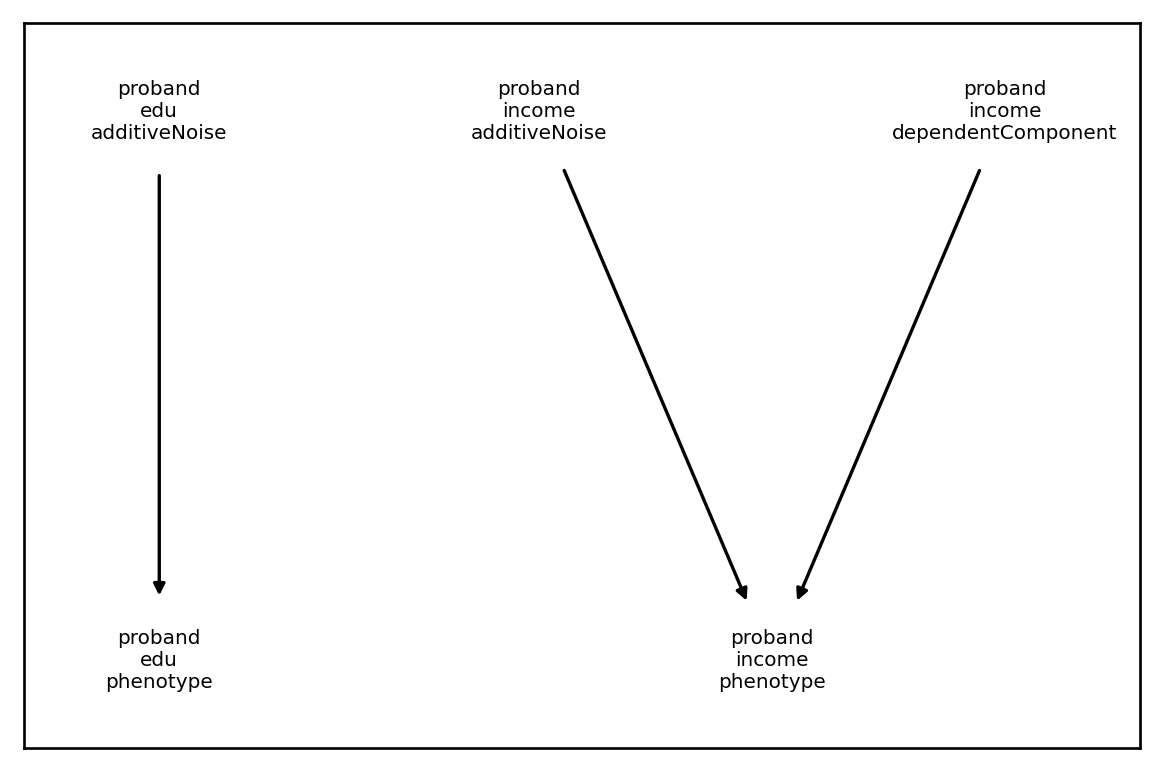

In [22]:
iind = xft.index.ComponentIndex(['edu','income','income'], 
                                ['additiveNoise','additiveNoise','dependentComponent'])

strans = xft.arch.SumAllTransformation(input_cindex=iind) 
strans.draw_dependency_graph()
strans

Looking at the result, we see that everything is is as expected:

phenotype_name                                               edu  \
component_name                                     additiveNoise   
vorigin_relative                                         proband   
phenotype_name component_name     vorigin_relative                 
edu            additiveNoise      proband               1.000000   
income         additiveNoise      proband               0.000002   
               dependentComponent proband               1.000000   
edu            phenotype          proband               1.000000   
income         phenotype          proband               0.510179   

phenotype_name                                            income  \
component_name                                     additiveNoise   
vorigin_relative                                         proband   
phenotype_name component_name     vorigin_relative                 
edu            additiveNoise      proband               0.000002   
income         additiveNoise      proband               1.000000   
               dependentComponent proband               0.000002   
edu            phenotype          proband               0.000002   
income         phenotype          proband               0.488448   

phenotype_name                                                         \
component_name                                     dependentComponent   
vorigin_relative                                              proband   
phenotype_name component_name     vorigin_relative                      
edu            additiveNoise      proband                    1.000000   
income         additiveNoise      proband                    0.000002   
               dependentComponent proband                    1.000000   
edu            phenotype          proband                    1.000000   
income         phenotype          proband                    0.510179   

phenotype_name                                           edu    income  
component_name                                     phenotype phenotype  
vorigin_relative                                     proband   proband  
phenotype_name component_name     vorigin_relative                      
edu            additiveNoise      proband           1.000000  0.510179  
income         additiveNoise      proband           0.000002  0.488448  
               dependentComponent proband           1.000000  0.510179  
edu            phenotype          proband           1.000000  0.510179  
income         phenotype          proband           0.510179  1.000000

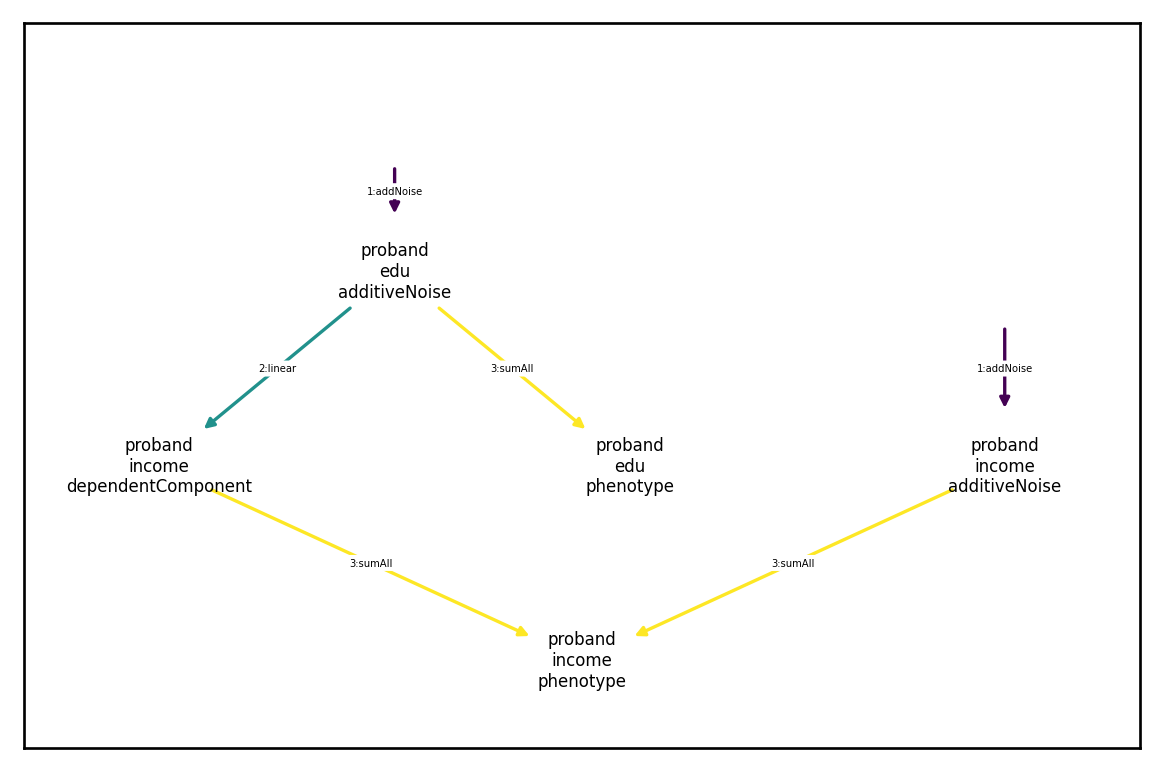

In [23]:
demo =  xft.sim.DemoSimulation()

test_sim = xft.sim.Simulation(founder_haplotypes=demo.haplotypes,
                              mating_regime=demo.mating_regime,
                              recombination_map= demo.recombination_map,
                              architecture = xft.arch.Architecture([ncomp, ccomp, strans]),
                              statistics=[xft.stats.SampleStatistics()],)

test_sim.architecture.draw_dependency_graph()
test_sim.run(1)
pd = test_sim.phenotypes.xft.as_pd()
pd.corr()**2

### Multivariate causal dependence


No suppose we assume income is affected by not just a single education factor, but by education and some measure of "opportunity".

Another simple model generative model might look like this

$$\text{Edu}_\text{noise}\sim N(0,1)$$
$$\text{Opportunity}_\text{noise}\sim N(0,1)$$
$$\text{Income}_\text{noise}\sim N(0,.5)$$
$$\text{Income}=\text{Income}_\text{noise} +\text{Edu}_\text{noise}\sqrt{.25} +\text{Opportunity}_\text{noise}\sqrt{.25}$$

In this case, everything will be the same except that our linear transformation will be 2x1:


phenotype_name                                               edu  \
component_name                                     additiveNoise   
vorigin_relative                                         proband   
phenotype_name component_name     vorigin_relative                 
edu            additiveNoise      proband               1.000000   
opportunity    additiveNoise      proband               0.000394   
income         additiveNoise      proband               0.000388   
               dependentComponent proband               0.509921   
edu            phenotype          proband               1.000000   
opportunity    phenotype          proband               0.000394   
income         phenotype          proband               0.238490   

phenotype_name                                       opportunity  \
component_name                                     additiveNoise   
vorigin_relative                                         proband   
phenotype_name component_name     vorigin_relative                 
edu            additiveNoise      proband               0.000394   
opportunity    additiveNoise      proband               1.000000   
income         additiveNoise      proband               0.002209   
               dependentComponent proband               0.509921   
edu            phenotype          proband               0.000394   
opportunity    phenotype          proband               1.000000   
income         phenotype          proband               0.286104   

phenotype_name                                            income  \
component_name                                     additiveNoise   
vorigin_relative                                         proband   
phenotype_name component_name     vorigin_relative                 
edu            additiveNoise      proband               0.000388   
opportunity    additiveNoise      proband               0.002209   
income         additiveNoise      proband               1.000000   
               dependentComponent proband               0.000366   
edu            phenotype          proband               0.000388   
opportunity    phenotype          proband               0.002209   
income         phenotype          proband               0.505800   

phenotype_name                                                         \
component_name                                     dependentComponent   
vorigin_relative                                              proband   
phenotype_name component_name     vorigin_relative                      
edu            additiveNoise      proband                    0.509921   
opportunity    additiveNoise      proband                    0.509921   
income         additiveNoise      proband                    0.000366   
               dependentComponent proband                    1.000000   
edu            phenotype          proband                    0.509921   
opportunity    phenotype          proband                    0.509921   
income         phenotype          proband                    0.513326   

phenotype_name                                           edu opportunity  \
component_name                                     phenotype   phenotype   
vorigin_relative                                     proband     proband   
phenotype_name component_name     vorigin_relative                         
edu            additiveNoise      proband           1.000000    0.000394   
opportunity    additiveNoise      proband           0.000394    1.000000   
income         additiveNoise      proband           0.000388    0.002209   
               dependentComponent proband           0.509921    0.509921   
edu            phenotype          proband           1.000000    0.000394   
opportunity    phenotype          proband           0.000394    1.000000   
income         phenotype          proband           0.238490    0.286104   

phenotype_name                                        income  
component_name                                   

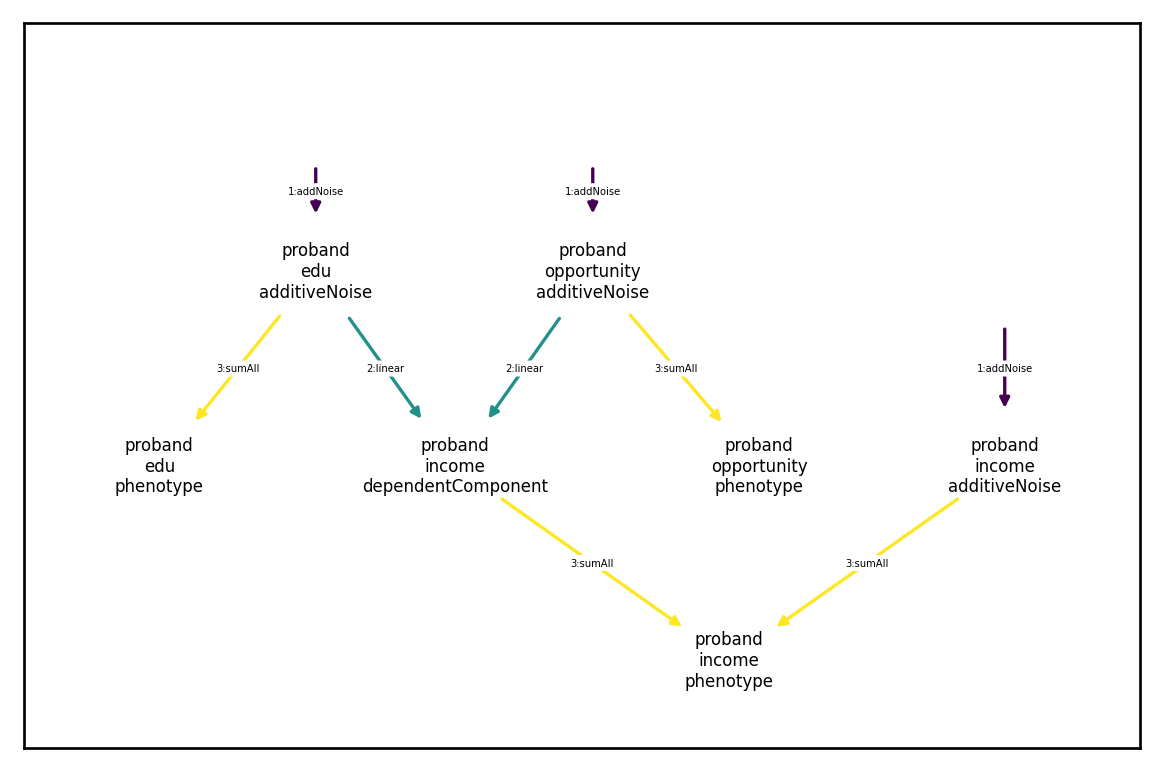

In [24]:
ncomp = xft.arch.AdditiveNoiseComponent(variances=[1,1,.5], 
                                        phenotype_name=['edu', 'opportunity', 'income'])
input_ind = xft.index.ComponentIndex(['edu','opportunity'], ['additiveNoise','additiveNoise'])
output_ind = xft.index.ComponentIndex(['income'], ['dependentComponent'])
coefficient_matrix = np.array([[np.sqrt(.25),np.sqrt(.25)]])

ccomp = xft.arch.LinearTransformationComponent(input_ind, output_ind, 
                                               coefficient_matrix, normalize = True)
sind = xft.index.ComponentIndex(['edu','opportunity','income','income'], 
                                ['additiveNoise','additiveNoise','additiveNoise','dependentComponent'])

strans = xft.arch.SumAllTransformation(input_cindex=sind) 

test_sim = xft.sim.Simulation(founder_haplotypes=demo.haplotypes,
                              mating_regime=demo.mating_regime,
                              recombination_map= demo.recombination_map,
                              architecture = xft.arch.Architecture([ncomp, ccomp, strans]),
                              statistics=[xft.stats.SampleStatistics()],)

test_sim.architecture.draw_dependency_graph()
test_sim.run(1)
pd = test_sim.phenotypes.xft.as_pd()
pd.corr()**2

## Vertical transmission

### Univariate vertical transimission

Vertical transmission refers to causal dependence across parent and offspring generations. For example, we might want to model the inheritance of wealth across generations. One generative generative model could look like this:

$$\text{Wealth}_\text{noise}\sim N(0,.5)$$
$$\text{Wealth}_\text{vertical} = (\text{Wealth}_\text{maternal} + \text{Wealth}_\text{paternal})\sqrt{(1/4)}$$
$$\text{Wealth}_\text{phenotype} = \text{Wealth}_\text{vertical} + \text{Wealth}_\text{noise}$$

I.e., half of wealth is individual specific noise and half is inherited from ones parents. 

Specifying a linear transmission like this is quite similar to the previous example of causal dependencies, only the inputs refer to parent generation (as specified by `vorigin_relative`; see [the tutorial on component indexing for further details](./indexing.ipynb)) rather than the offspring generation. However, in addition to specifying the transmission as a linear opeartion, **we have to specify a way to initialize the transmitted component in the founder generation**. By default, we set to this to independent Gaussian noise with user-supplied variance $\sigma^2_\text{founder}$ such that $\text{Wealth}_\text{vertical}$ is drawn from this distribution in the first generation (when, in the context of our simulation, no parents exist to pass on wealth).

We demonstrate this below:

<LinearVerticalComponent>
                                 wealth phenotype 0 output  \
wealth_vertical_-1_intermediate                        0.5   

                                 wealth phenotype 1 output  
wealth_vertical_-1_intermediate                        0.5  

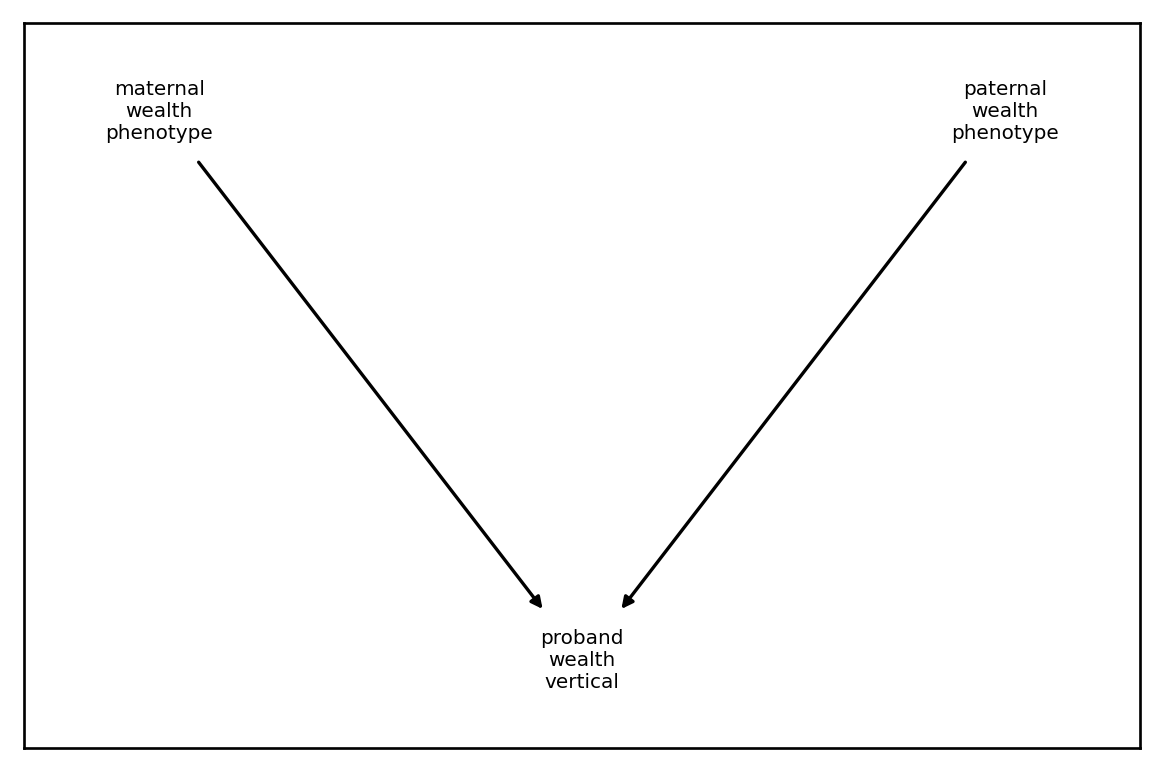

In [25]:
## noise component
ncomp = xft.arch.AdditiveNoiseComponent(variances=[.5], 
                                        phenotype_name=['wealth'])

## transmitted component:
vert_input = xft.index.ComponentIndex.from_product(['wealth'], ['phenotype'], [0,1])
vert_input.comp_type ='output'
vert_output = xft.index.ComponentIndex.from_product(['wealth'], ['vertical'], [-1])
founder_variances = np.sqrt([.5,.5]) ## must be same length is inputs
coefficient_matrix = np.array([[np.sqrt(.25),np.sqrt(.25)]])

vtcomp = xft.arch.LinearVerticalComponent(input_cindex=vert_input,
                                          output_cindex=vert_output,
                                          founder_variances=founder_variances,
                                          coefficient_matrix=coefficient_matrix,
                                          normalize = False)
vtcomp.draw_dependency_graph()
vtcomp

phenotype_name                                        wealth            \
component_name                                 additiveNoise phenotype   
vorigin_relative                                     proband    mother   
phenotype_name component_name vorigin_relative                           
wealth         additiveNoise  proband               1.000000  0.000079   
               phenotype      mother                0.000079  1.000000   
                              father                0.001388  0.000203   
               vertical       proband               0.000397  0.507700   
               phenotype      proband               0.539527  0.227734   

phenotype_name                                                                
component_name                                            vertical phenotype  
vorigin_relative                                  father   proband   proband  
phenotype_name component_name vorigin_relative                                
wealth         additiveNoise  proband           0.001388  0.000397  0.539527  
               phenotype      mother            0.000203  0.507700  0.227734  
                              father            1.000000  0.506551  0.260018  
               vertical       proband           0.506551  1.000000  0.480353  
               phenotype      proband           0.260018  0.480353  1.000000

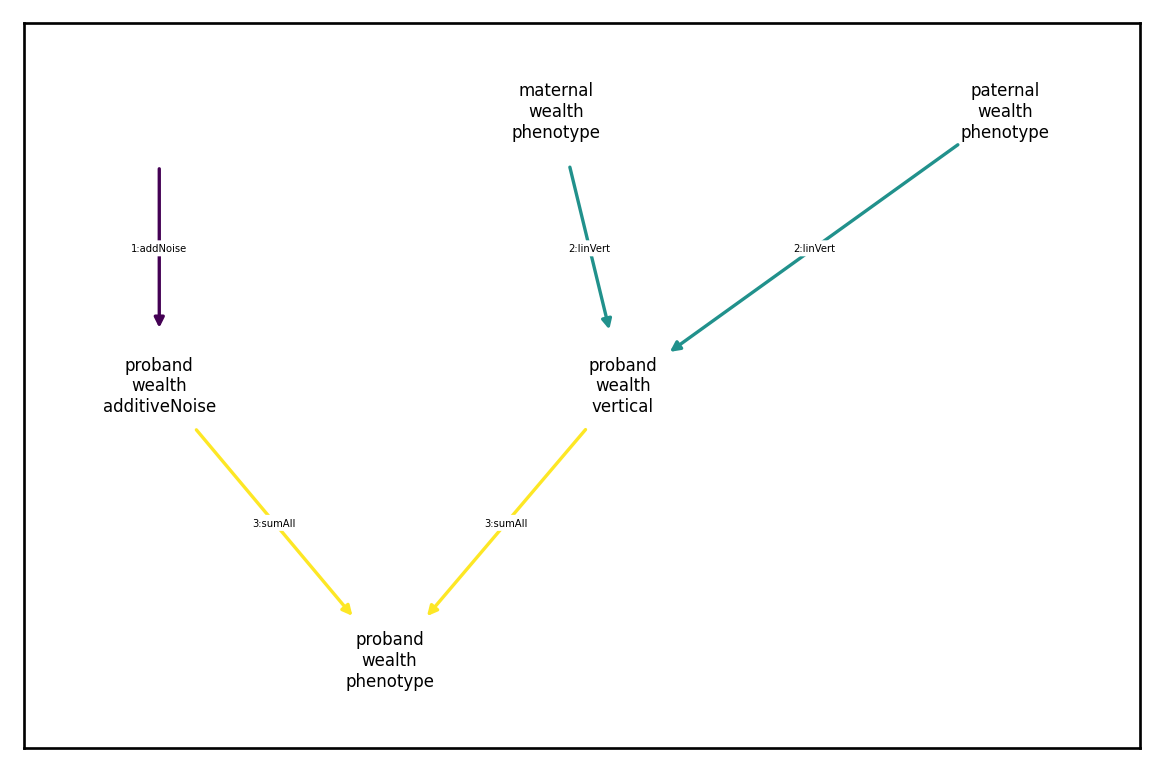

In [26]:

sind = xft.index.ComponentIndex.from_product(['wealth'],
                                             ['additiveNoise','vertical'])

strans = xft.arch.SumAllTransformation(input_cindex=sind) 

test_sim = xft.sim.Simulation(founder_haplotypes=demo.haplotypes,
                              mating_regime=demo.mating_regime,
                              recombination_map= demo.recombination_map,
                              architecture = xft.arch.Architecture([ncomp, vtcomp, strans]),
                              statistics=[xft.stats.SampleStatistics()],)
test_sim.architecture.draw_dependency_graph()
test_sim.run(2)
pd = test_sim.phenotypes.xft.as_pd()
pd.corr()**2


### Multivariate vertical transimission

We might have more complex patterns of inheritance. For example, consider the following generative model:


$$\text{Edu}_\text{noise}\sim N(0,.5)$$
$$\text{Wealth}_\text{noise}\sim N(0,.5)$$
$$\text{Edu}_\text{phenotype}=\text{Edu}_\text{inherited}+\text{Edu}_\text{noise}$$
$$\text{Wealth}_\text{phenotype}=\text{Wealth}_\text{inherited}+\text{Wealth}_\text{noise}$$


where 
$$\begin{pmatrix}\text{Edu}_{\text{inherited}}\\
\text{Wealth}_{\text{inherited}}
\end{pmatrix}\stackrel{iid}{\sim}N(0,1/2)$$
at generation zero and 
$$
\begin{pmatrix}\text{Edu}_{\text{inherited}}\\
\text{Wealth}_{\text{inherited}}
\end{pmatrix}=\begin{pmatrix}2^{-1} & 2^{-1} & 0 & 0\\
2^{-3/2} & 2^{-3/2} & 2^{-3/2} & 2^{-3/2}
\end{pmatrix}\begin{pmatrix}\tilde{\text{Edu}}_{\text{maternal}}\\
\tilde{\text{Edu}}_{\text{paternal}}\\
\tilde{\text{Wealth}}_{\text{maternal}}\\
\tilde{\text{Wealth}}_{\text{paternal}}
\end{pmatrix}$$every subsequent generation, where $\tilde{[\cdot]}$ denotes a standardized quantity. Under this model, half the variance in wealth and education are both independent Gaussian noise, half the variance in education is attributable to parental education, and a quarter each of the variance in wealth is attributable to parental education and parental wealth, respectively. We code this as follows:



<LinearVerticalComponent>
                                    normalized_education phenotype 0 output  \
education_vertical_-1_intermediate                                 0.500000   
wealth_vertical_-1_intermediate                                    0.353553   

                                    normalized_education phenotype 1 output  \
education_vertical_-1_intermediate                                 0.500000   
wealth_vertical_-1_intermediate                                    0.353553   

                                    normalized_wealth phenotype 0 output  \
education_vertical_-1_intermediate                              0.000000   
wealth_vertical_-1_intermediate                                 0.353553   

                                    normalized_wealth phenotype 1 output  
education_vertical_-1_intermediate                              0.000000  
wealth_vertical_-1_intermediate                                 0.353553  

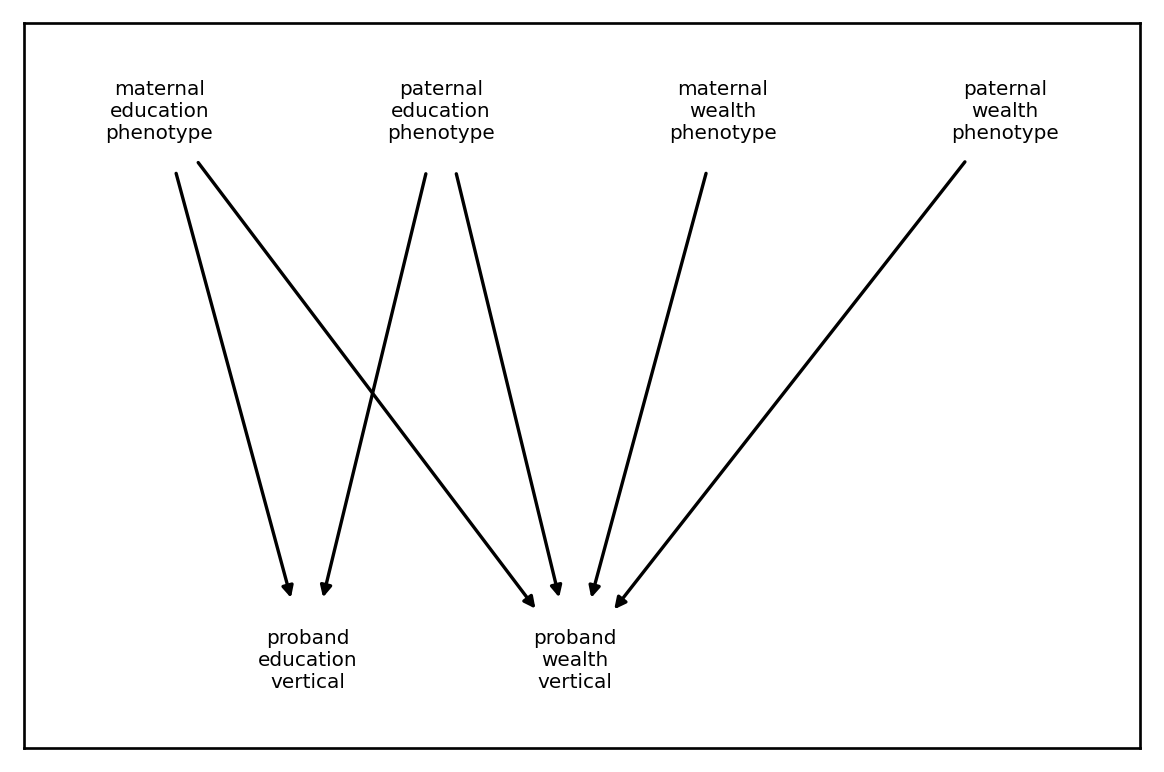

In [27]:
## noise component
ncomp = xft.arch.AdditiveNoiseComponent(variances=[.5,.5], 
                                        phenotype_name=['education', 'wealth'])

## transmitted component:
vert_input = xft.index.ComponentIndex.from_product(['education', 'wealth'], ['phenotype'], [0,1])
vert_input.comp_type ='output'
vert_output = xft.index.ComponentIndex.from_product(['education', 'wealth'], ['vertical'], [-1])
founder_variances = np.sqrt([.5,.5,.5,.5]) ## must be same length is inputs
coefficient_matrix = np.array([[np.sqrt(.25),np.sqrt(.125)],
                               [np.sqrt(.25),np.sqrt(.125)],
                               [np.sqrt(0),np.sqrt(.125)],
                               [np.sqrt(0),np.sqrt(.125)],
                              ]).T

vtcomp = xft.arch.LinearVerticalComponent(input_cindex=vert_input,
                                          output_cindex=vert_output,
                                          founder_variances=founder_variances,
                                          coefficient_matrix=coefficient_matrix,
                                          normalize = True)
vtcomp.draw_dependency_graph()
vtcomp

In [28]:

sind = xft.index.ComponentIndex.from_product(['education','wealth'],
                                             ['additiveNoise','vertical'])

strans = xft.arch.SumAllTransformation(input_cindex=sind) 

test_sim = xft.sim.Simulation(founder_haplotypes=demo.haplotypes,
                              mating_regime=demo.mating_regime,
                              recombination_map= demo.recombination_map,
                              architecture = xft.arch.Architecture([ncomp, vtcomp, strans]),
                              statistics=[xft.stats.SampleStatistics()],)

test_sim.run(1)
pd = test_sim.phenotypes.xft.as_pd()
pd.corr()**2

phenotype_name                                     education        wealth  \
component_name                                 additiveNoise additiveNoise   
vorigin_relative                                     proband       proband   
phenotype_name component_name vorigin_relative                               
education      additiveNoise  proband               1.000000      0.000857   
wealth         additiveNoise  proband               0.000857      1.000000   
education      phenotype      mother                0.000002      0.000461   
                              father                0.000995      0.000001   
wealth         phenotype      mother                0.000625      0.000570   
                              father                0.000006      0.000743   
education      vertical       proband               0.000534      0.000207   
wealth         vertical       proband               0.000026      0.000136   
education      phenotype      proband               0.498062      0.000120   
wealth         phenotype      proband               0.000582      0.504927   

phenotype_name                                 education              wealth  \
component_name                                 phenotype           phenotype   
vorigin_relative                                  mother    father    mother   
phenotype_name component_name vorigin_relative                                 
education      additiveNoise  proband           0.000002  0.000995  0.000625   
wealth         additiveNoise  proband           0.000461  0.000001  0.000570   
education      phenotype      mother            1.000000  0.000116  0.000167   
                              father            0.000116  1.000000  0.000047   
wealth         phenotype      mother            0.000167  0.000047  1.000000   
                              father            0.000854  0.000089  0.001322   
education      vertical       proband           0.505388  0.505388  0.000193   
wealth         vertical       proband           0.265646  0.243547  0.267265   
education      phenotype      proband           0.252852  0.231372  0.000779   
wealth         phenotype      proband           0.142704  0.120086  0.120418   

phenotype_name                                           education    wealth  \
component_name                                            vertical  vertical   
vorigin_relative                                  father   proband   proband   
phenotype_name component_name vorigin_relative                                 
education      additiveNoise  proband           0.000006  0.000534  0.000026   
wealth         additiveNoise  proband           0.000743  0.000207  0.000136   
education      phenotype      mother            0.000854  0.505388  0.265646   
                              father            0.000089  0.505388  0.243547   
wealth         phenotype      mother            0.001322  0.000193  0.267265   
                              father            1.000000  0.000193  0.267268   
education      vertical       proband           0.000193  1.000000  0.503528   
wealth         vertical       proband           0.267268  0.503528  1.000000   
education      phenotype      proband           0.000065  0.478826  0.249211   
wealth         phenotype      proband           0.146627  0.259506  0.506739   

phenotype_name                                 education    wealth  
component_name                                 phenotype phenotype  
vorigin_relative                                 proband   proband  
phenotype_name component_name vorigin_relative                      
education      additiveNoise  proband           0.498062  0.000582  
wealth         additiveNoise  proband           0.000120  0.504927  
education      phenotype      mother            0.252852  0.142704  
                              father            0.231372  0.120086  
wealth         phenotype      mother            0.000779  0.120418  
                              father        

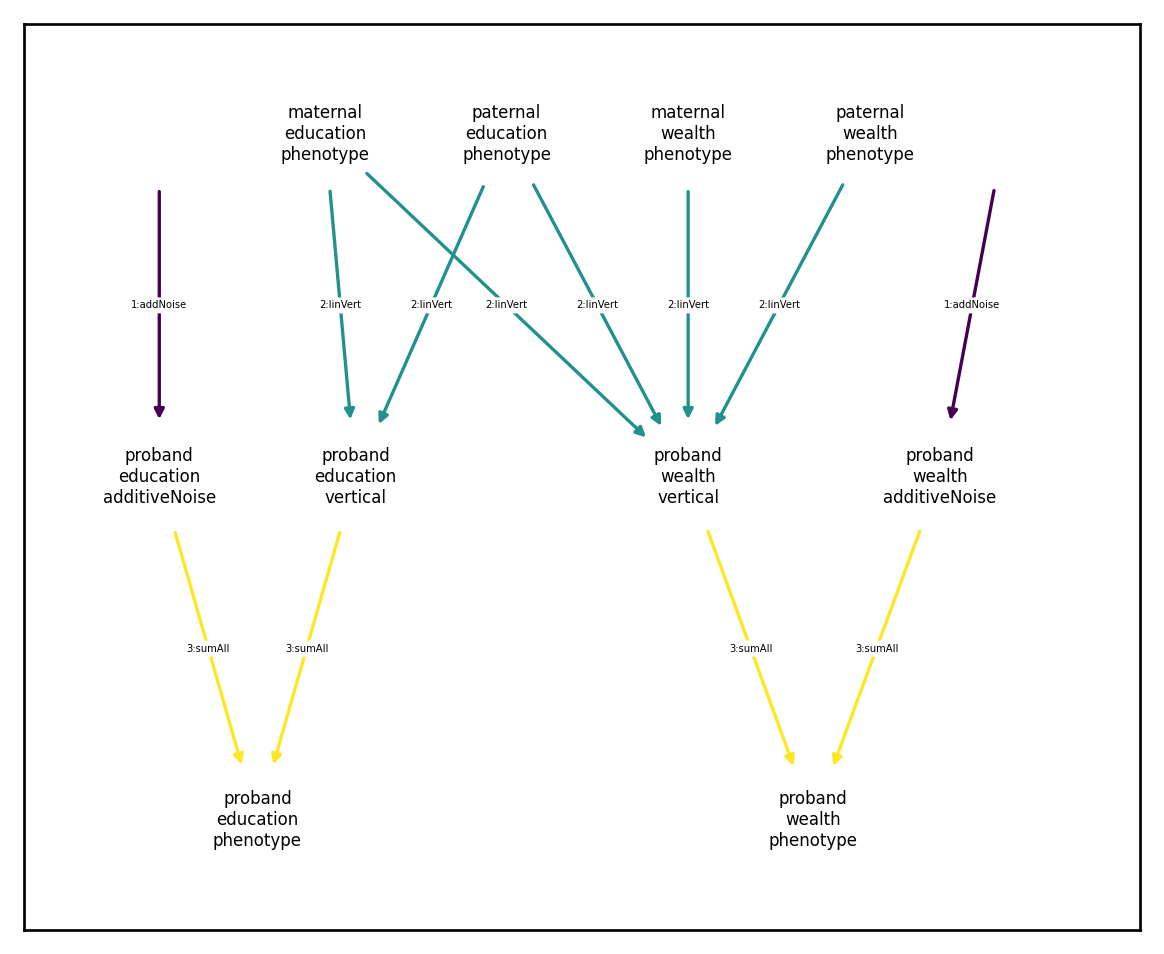

In [32]:
plt.rcParams['figure.figsize'] = [6.,5.] ## better looking plots
xft.arch.Architecture([ncomp, vtcomp, strans]).draw_dependency_graph()

## Sum transformations

We nearly always will want to include a component that sums existing components to create composite phenotypes. This is straight forward to accomplish using the `SumAllTransformation` component. To specify a `SumAllTransformation`, we only need to provide the input component index and it will sum input components corresponding to the same phenotype:


<class 'xftsim.arch.SumAllTransformation'>

## INPUTS:
 - haplotypes: False
 - phenotype components:
<ComponentIndex>
  5 components of 2 phenotypes spanning 1 generation
                       phenotype_name component_name  vorigin_relative  \
component                                                                
BMD.BMD1.proband                  BMD           BMD1                -1   
BMD.BMD2.proband                  BMD           BMD2                -1   
BMD.BMD3.proband                  BMD           BMD3                -1   
height.height1.proband         height        height1                -1   
height.height2.proband         height        height2                -1   

                           comp_type  
component                             
BMD.BMD1.proband        intermediate  
BMD.BMD2.proband        intermediate  
BMD.BMD3.proband        intermediate  
height.height1.proband  intermediate  
height.height2.proband  intermediate  

## OUTPUTS:
 - phenotype components:

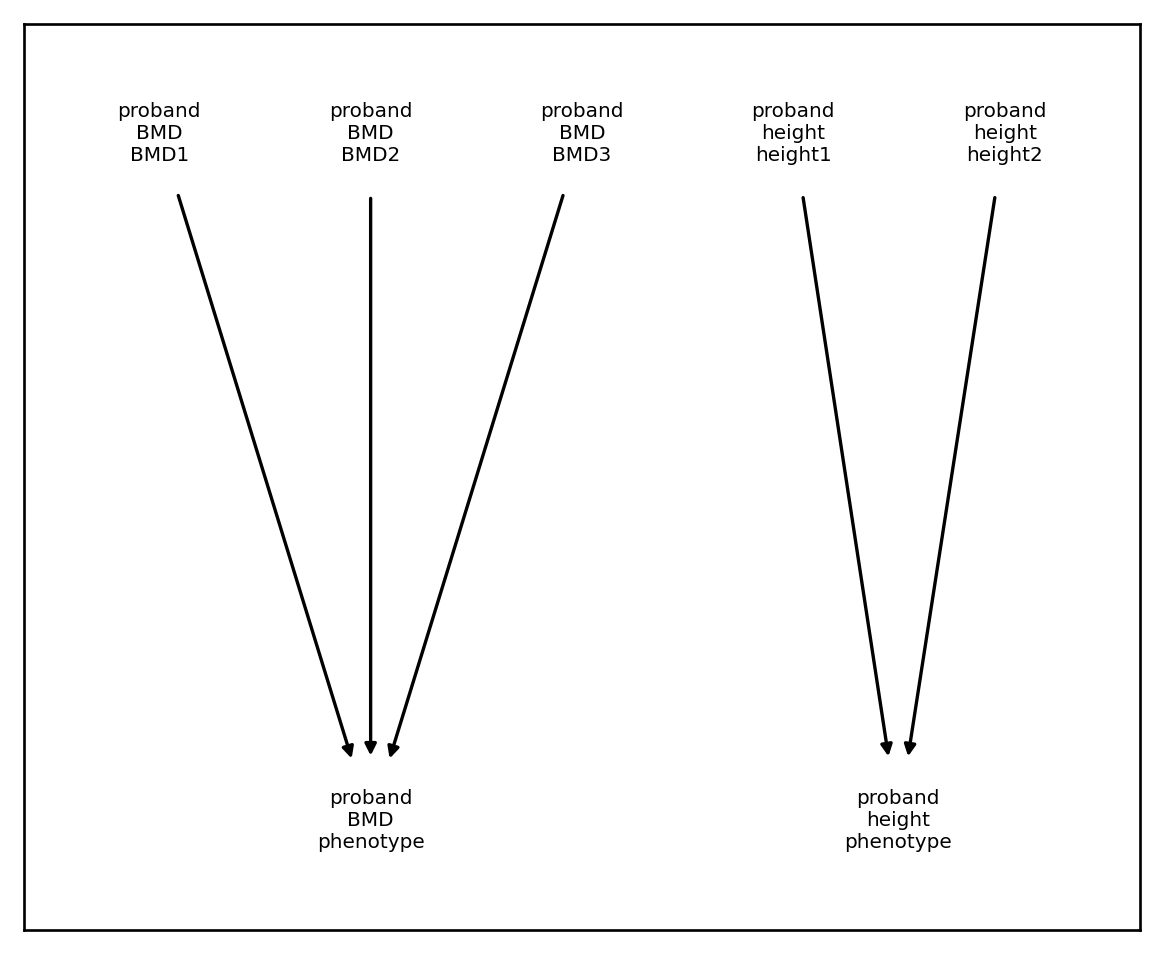

In [33]:
input_cindex=xft.index.ComponentIndex(['BMD', 'BMD', 'BMD', 'height', 'height'], 
                                      ['BMD1', 'BMD2', 'BMD3', 'height1', 'height2'])

strans = xft.arch.SumAllTransformation(input_cindex)
strans.draw_dependency_graph()
strans

## Binarizations

:::{note}

Coming soon

:::

## Architecture objects: order matters

As we have seen throughout, an `Architecture` object is nothing more than a collection of `ArchitectureComponents`. These components are constructed in order (e.g., you can't sum components that don't yet exist), and can be arbitrarily complicated. We demonstrate a complex simulation below:

![Complex simulation](../_static/complexsim.png)

Here we assume that height is heritable with heritability 0.6, but that educational attainment and wealth are not. On the other hand, we assume that the variation in educational attainment is attributable in equal parts to parental educational attainment, parental wealth, and random noise. We also assume that an individual's wealth is determined in equal parts by their own educational attainment, their parent's wealth, and random noise. Thus we have additive genetic, additive noise, multivariate vertical transmission, and causal dependence. We try to implement this in `xftsim` as follows: 


In [34]:
## This example won't work
founder_haplotypes = xft.founders.founder_haplotypes_uniform_AFs(n=4000,
                                                                 m=800)
rmap = xft.reproduce.RecombinationMap.constant_map_from_haplotypes(founder_haplotypes,
                                                                   .1)

genetic_effects = xft.effect.GCTAEffects(vg=[.6],
                                         variant_indexer=founder_haplotypes.xft.get_variant_indexer(),
                                         component_indexer=xft.index.ComponentIndex(['height'],
                                                                                    ['genetic']))
genetic_comp = xft.arch.AdditiveGeneticComponent(genetic_effects)

noise_comp = xft.arch.AdditiveNoiseComponent(variances=[.4,1/3,1/3],
                                             component_index=xft.index.ComponentIndex.from_product(['height','edu','wealth'],
                                                                                                   ['noise']))
vert_input = xft.index.ComponentIndex.from_product(['edu', 'wealth'], ['phenotype'], [0,1])
vert_input.comp_type ='output'
vert_output = xft.index.ComponentIndex.from_product(['edu', 'wealth'], ['vertical'], [-1])
founder_variances = np.sqrt([.5,.5,.5,.5]) ## must be same length is inputs
coefficient_matrix = np.array([[np.sqrt(1/3),np.sqrt(1/6)],
                               [np.sqrt(1/3),np.sqrt(1/6)],
                               [np.sqrt(0),np.sqrt(1/6)],
                               [np.sqrt(0),np.sqrt(1/6)],
                              ]).T

vt_comp = xft.arch.LinearVerticalComponent(input_cindex=vert_input,
                                          output_cindex=vert_output,
                                          founder_variances=[1.,1.,1.,1.,],
                                          coefficient_matrix=coefficient_matrix,
                                          normalize = True)
input_ind = xft.index.ComponentIndex(['edu'], ['phenotype'])
output_ind = xft.index.ComponentIndex(['wealth'], ['dependent'])
coefficient_matrix = np.array([[np.sqrt(1/3)]])

causal_comp = xft.arch.LinearTransformationComponent(input_ind, output_ind, 
                                               coefficient_matrix, normalize = True)
input_cindex=xft.index.ComponentIndex(['height','height','edu', 'edu', 'wealth', 'wealth','wealth'], 
                                      ['genetic','noise','noise', 'vertical', 'noise', 'vertical','dependent'])

strans = xft.arch.SumAllTransformation(input_cindex)

arch = xft.arch.Architecture([genetic_comp,
                              noise_comp,
                              causal_comp,
                              vt_comp,
                              strans])


/home/rsb/Dropbox/ftsim/xftsim/xftsim/arch.py:1549: UserWarning: Architecture contains out-of-order dependencies! This is probably a mistake, check dependency_graph using xft.arch.Architecture.draw_dependency_graph()
  warnings.warn('Architecture contains out-of-order dependencies! This is probably a mistake, check dependency_graph using xft.arch.Architecture.draw_dependency_graph()')
/home/rsb/Dropbox/ftsim/xftsim/xftsim/arch.py:1551: UserWarning: Architecture contains circular dependencies! This is probably a mistake, check dependency_graph using xft.arch.Architecture.draw_dependency_graph()
  warnings.warn('Architecture contains circular dependencies! This is probably a mistake, check dependency_graph using xft.arch.Architecture.draw_dependency_graph()')


In [35]:
mating = xft.mate.LinearAssortativeMatingRegime(r=.25,
                                                component_index =xft.index.ComponentIndex.from_product(['edu', 'wealth','height'], ['phenotype']), 
                                                offspring_per_pair=2,
                                                mates_per_female=1)

In [36]:
sim = xft.sim.Simulation(architecture=arch,
                   founder_haplotypes=founder_haplotypes,
                   recombination_map=rmap,
                   mating_regime=mating,
                   statistics=[xft.stats.SampleStatistics(),
                               xft.stats.MatingStatistics(),
                               xft.stats.HasemanElstonEstimator(randomized=True)])
sim.run(1)
sim.phenotypes.xft.as_pd()

phenotype_name       height                 edu    wealth       edu    wealth  \
component_name      genetic     noise     noise     noise phenotype dependent   
vorigin_relative    proband   proband   proband   proband   proband   proband   
iid    fid    sex                                                               
0_0    0_0    0   -1.101272 -0.466122  0.241528  0.097133  0.322472       NaN   
0_1    0_1    1   -0.291687 -0.360123  0.182665  0.408468  0.106200       NaN   
0_2    0_2    0    1.564455 -1.208238  0.146314 -1.008075  0.941820       NaN   
0_3    0_3    1    0.256901  0.731013  0.421608 -0.261024 -0.471455       NaN   
0_4    0_4    0   -0.441650  1.238165 -0.141177  0.063126  1.265770       NaN   
...                     ...       ...       ...       ...       ...       ...   
0_3995 0_3995 1    1.534601 -0.212587 -0.884755 -0.476098 -0.787108       NaN   
0_3996 0_3996 0   -0.848166  0.499466 -0.057256  0.092454 -1.007816       NaN   
0_3997 0_3997 1   -0.140357 -0.672756 -0.715498 -0.597222 -0.753880       NaN   
0_3998 0_3998 0    0.936778  0.241881  0.250365 -0.039575  0.049663       NaN   
0_3999 0_3999 1   -0.680978 -0.032805 -0.053277  0.505742  0.590953       NaN   

phenotype_name          edu              wealth                 edu    wealth  \
component_name    phenotype           phenotype            vertical  vertical   
vorigin_relative     mother    father    mother    father   proband   proband   
iid    fid    sex                                                               
0_0    0_0    0   -0.628634  0.709235  1.018214 -0.091693  0.080945  0.431480   
0_1    0_1    1   -0.316022  0.131428  1.111602  0.093162 -0.076465  0.433636   
0_2    0_2    0    1.157615  0.181412 -0.371868  0.241415  0.795506  0.507355   
0_3    0_3    1   -0.625062 -0.968164 -1.419487  0.520203 -0.893064 -0.998924   
0_4    0_4    0    1.660386  0.737996 -0.916003  0.483118  1.406947  0.817075   
...                     ...       ...       ...       ...       ...       ...   
0_3995 0_3995 1    0.442468 -0.314927  0.528612 -0.496630  0.097647  0.078811   
0_3996 0_3996 0   -1.920869  0.206771  0.940940  1.768656 -0.950559  0.430252   
0_3997 0_3997 1    0.300538 -0.409186  0.255610  0.579280 -0.038381  0.310881   
0_3998 0_3998 0   -1.763167  1.340426 -0.638864 -1.092342 -0.200702 -0.850245   
0_3999 0_3999 1    1.054376  0.022916 -0.345385  1.878949  0.644230  1.079769   

phenotype_name       height    wealth  
component_name    phenotype phenotype  
vorigin_relative    proband   proband  
iid    fid    sex                      
0_0    0_0    0   -1.567394       NaN  
0_1    0_1    1   -0.651810       NaN  
0_2    0_2    0    0.356217       NaN  
0_3    0_3    1    0.987914       NaN  
0_4    0_4    0    0.796514       NaN  
...                     ...       ...  
0_3995 0_3995 1    1.322014       NaN  
0_3996 0_3996 0   -0.348701       NaN  
0_3997 0_3997 1   -0.813114       NaN  
0_3998 0_3998 0    1.178660       NaN  
0_3999 0_3999 1   -0.713783       NaN  

[4000 rows x 14 columns]

It looks like the simulation wasn't able to compute the 'dependent' or 'phenotype' components of 'wealth'. What happened here? Looking at the dependency graph (which colors edges in order of computation) we see we have a circular dependency:

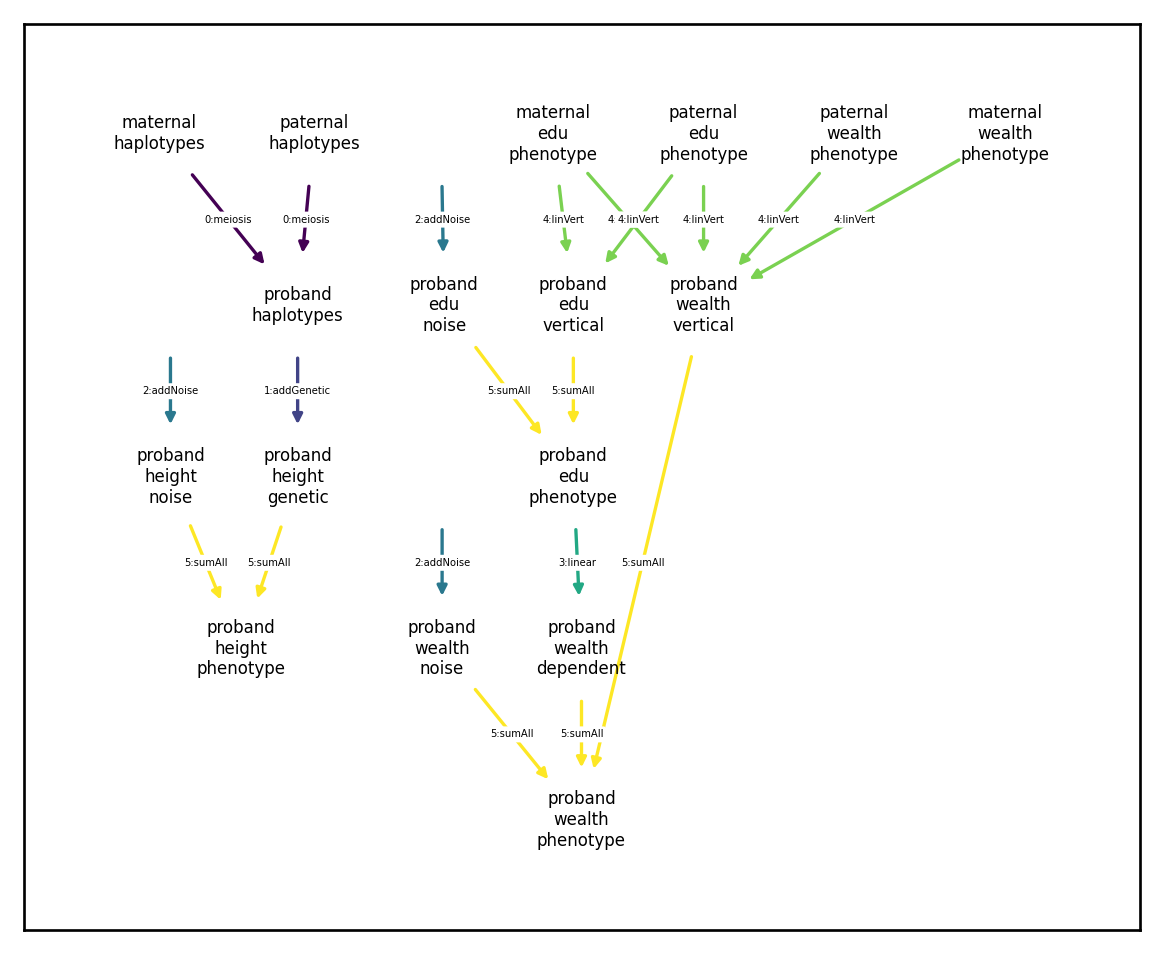

In [37]:
arch.draw_dependency_graph(font_size=5, node_size=1000)


Specifically, the `edu phenotype` node generated by the sum transformation (yellow arrows) but has a causal effect (teal arrow) on the `wealth dependent` component, which is again used by the sum transformation to construct the `wealth phenotype` component.

## Avoiding circular dependences

There are multiple ways to avoid this sort of circular dependency. The first would be to have the `wealth dependent` component depend directly on `edu noise` and `edu vertical`:



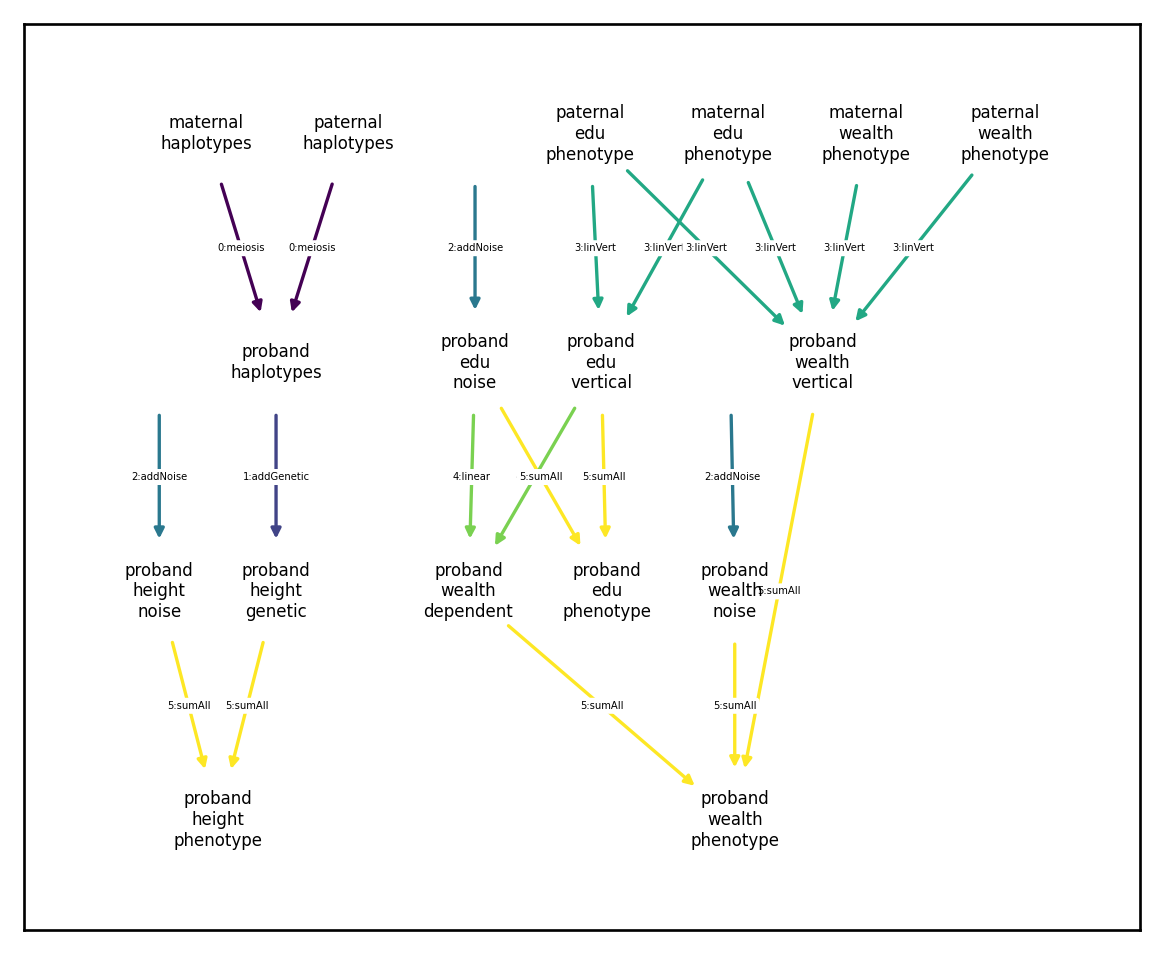

In [38]:
input_ind = xft.index.ComponentIndex.from_product(['edu'], ['noise', 'vertical'])
output_ind = xft.index.ComponentIndex(['wealth'], ['dependent'])
coefficient_matrix = np.array([[np.sqrt(1/6),np.sqrt(1/6)]])

causal_comp_redux = xft.arch.LinearTransformationComponent(input_ind, output_ind, 
                                               coefficient_matrix, normalize = True)
input_cindex=xft.index.ComponentIndex(['height','height','edu', 'edu', 'wealth', 'wealth','wealth'], 
                                      ['genetic','noise','noise', 'vertical', 'noise', 'vertical','dependent'])

strans = xft.arch.SumAllTransformation(input_cindex)

arch_redux1 = xft.arch.Architecture([genetic_comp,
                                     noise_comp,
                                     vt_comp,
                                     causal_comp_redux,
                                     strans])
arch_redux1.draw_dependency_graph(font_size=5, node_size=1000)

We can tell that there are no circular dependencies because all directed paths through the network travel through each color at most once. An alternative method for avoid circular dependences would be to keep the dependence between `wealth dependent` and `edu phenotype` but compute the sums in two steps:

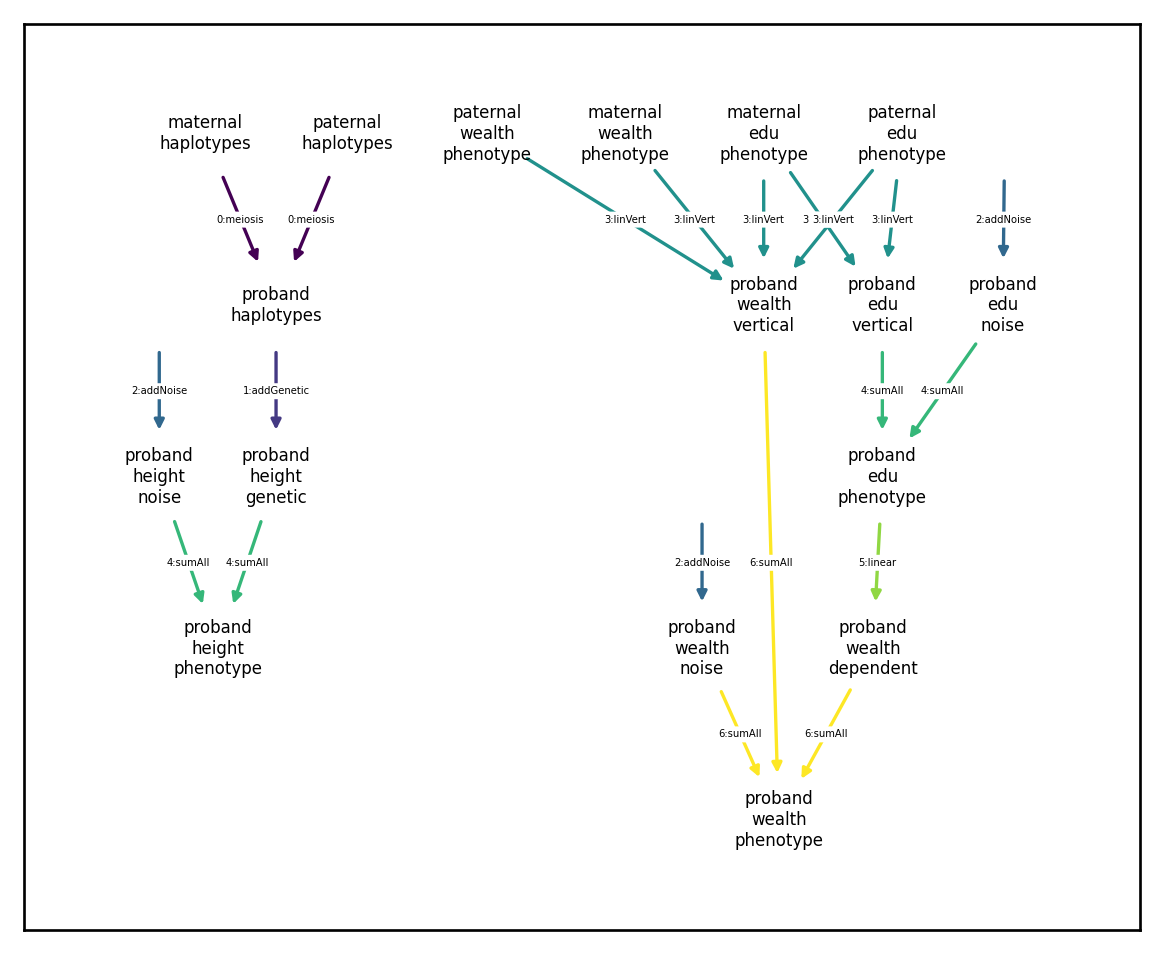

In [39]:
input_cindex=xft.index.ComponentIndex(['height','height','edu', 'edu'], 
                                      ['genetic','noise','noise', 'vertical'])

strans_redux1 = xft.arch.SumAllTransformation(input_cindex)
                                                                   
input_cindex=xft.index.ComponentIndex(['wealth', 'wealth','wealth'], 
                                      ['noise', 'vertical','dependent'])

strans_redux2 = xft.arch.SumAllTransformation(input_cindex)
                                                                                                  
                                                                   
arch_redux2 = xft.arch.Architecture([genetic_comp,
                                     noise_comp,
                                     vt_comp,
                                     strans_redux1,
                                     causal_comp,
                                     strans_redux2])
arch_redux2.draw_dependency_graph(font_size=5, node_size=800)

Both of these reformulations are equivalent and will produce expected results:

In [40]:
sim_redux1 = xft.sim.Simulation(architecture=arch_redux1,
                   founder_haplotypes=founder_haplotypes,
                   recombination_map=rmap,
                   mating_regime=mating,
                   statistics=[xft.stats.SampleStatistics(),
                               xft.stats.MatingStatistics(),
                               xft.stats.HasemanElstonEstimator(randomized=True)])
sim_redux1.run(1)
sim_redux1.phenotypes.xft.as_pd()

phenotype_name       height                 edu    wealth       edu            \
component_name      genetic     noise     noise     noise phenotype             
vorigin_relative    proband   proband   proband   proband    mother    father   
iid    fid    sex                                                               
0_0    0_0    0   -1.101272 -0.443415  0.668207 -0.496342  2.335213  2.200979   
0_1    0_1    1   -0.291687 -0.641795  0.283684 -0.013607  1.809368  0.841446   
0_2    0_2    0    1.564455  0.121725  0.412888  1.085446  0.256060  0.776945   
0_3    0_3    1    0.256901 -0.484351 -0.348864  0.060822  0.258078  0.949303   
0_4    0_4    0   -0.441650 -0.798620 -0.906873 -0.235947 -0.118050  0.573268   
...                     ...       ...       ...       ...       ...       ...   
0_3995 0_3995 1    1.534601  0.129564 -0.822703 -0.987844  0.796473 -1.139303   
0_3996 0_3996 0   -0.848166  0.219150 -0.430542  0.752007  0.074517 -0.522748   
0_3997 0_3997 1   -0.140357 -0.579840 -0.457745  0.523894 -0.433264  1.170434   
0_3998 0_3998 0    0.936778  0.455758  0.414072 -0.574930 -0.159043  2.304589   
0_3999 0_3999 1   -0.680978 -0.339524  0.248580 -0.112645  1.138490 -0.140208   

phenotype_name       wealth                 edu    wealth              height  \
component_name    phenotype            vertical  vertical dependent phenotype   
vorigin_relative     mother    father   proband   proband   proband   proband   
iid    fid    sex                                                               
0_0    0_0    0    0.560406 -0.859088  2.634153  1.743080  1.781734 -1.544687   
0_1    0_1    1   -0.733460  1.047139  1.536193  1.216185  0.965398 -0.933482   
0_2    0_2    0    2.354585  0.442318  0.587992  1.562261  0.582878  1.686181   
0_3    0_3    1   -0.361856  2.052686  0.689285  1.180309  0.100869 -0.227450   
0_4    0_4    0    1.160756 -0.863358  0.250343  0.301407 -0.508109 -1.240270   
...                     ...       ...       ...       ...       ...       ...   
0_3995 0_3995 1    0.812556  0.146773 -0.208152  0.247491 -0.677907  1.664165   
0_3996 0_3996 0   -0.112443  0.012603 -0.273341 -0.231967 -0.436266 -0.629016   
0_3997 0_3997 1   -1.141619  0.403311  0.412374 -0.008600 -0.113335 -0.720197   
0_3998 0_3998 0   -1.300853 -1.164761  1.231898 -0.135052  0.904805  1.392537   
0_3999 0_3999 1    0.645422 -1.084327  0.572676  0.228145  0.460377 -1.020502   

phenotype_name          edu    wealth  
component_name    phenotype phenotype  
vorigin_relative    proband   proband  
iid    fid    sex                      
0_0    0_0    0    3.302361  3.028472  
0_1    0_1    1    1.819877  2.167976  
0_2    0_2    0    1.000880  3.230585  
0_3    0_3    1    0.340421  1.342001  
0_4    0_4    0   -0.656530 -0.442650  
...                     ...       ...  
0_3995 0_3995 1   -1.030854 -1.418261  
0_3996 0_3996 0   -0.703883  0.083774  
0_3997 0_3997 1   -0.045371  0.401960  
0_3998 0_3998 0    1.645970  0.194824  
0_3999 0_3999 1    0.821256  0.575877  

[4000 rows x 14 columns]

In [41]:
sim_redux2 = xft.sim.Simulation(architecture=arch_redux2,
                   founder_haplotypes=founder_haplotypes,
                   recombination_map=rmap,
                   mating_regime=mating,
                   statistics=[xft.stats.SampleStatistics(),
                               xft.stats.MatingStatistics(),
                               xft.stats.HasemanElstonEstimator(randomized=True)])
sim_redux2.run(1)
sim_redux2.phenotypes.xft.as_pd()

phenotype_name       height                 edu    wealth       edu            \
component_name      genetic     noise     noise     noise phenotype             
vorigin_relative    proband   proband   proband   proband    mother    father   
iid    fid    sex                                                               
0_0    0_0    0   -1.101272 -0.997571 -0.286371  0.017414  1.388394  0.519995   
0_1    0_1    1   -0.291687 -0.116802 -0.107770 -0.542972  0.196249 -1.063237   
0_2    0_2    0    1.564455  0.307428 -0.838577  1.085479  1.015536 -1.156375   
0_3    0_3    1    0.256901  0.540909  0.606238 -0.835976  0.664364  1.929105   
0_4    0_4    0   -0.441650 -1.158010  0.027890  0.159385 -0.319625  0.499308   
...                     ...       ...       ...       ...       ...       ...   
0_3995 0_3995 1    1.534601  1.099554  0.343195  0.583978  1.004103  0.464900   
0_3996 0_3996 0   -0.848166 -0.221762  0.643381 -0.266004  0.283337 -0.189421   
0_3997 0_3997 1   -0.140357 -0.240442 -0.361796 -0.424735 -0.292312 -0.400030   
0_3998 0_3998 0    0.936778 -0.234855  1.219757  0.999266 -0.567264 -0.399390   
0_3999 0_3999 1   -0.680978 -0.369151  0.885436  1.049758  1.134351 -2.437645   

phenotype_name       wealth                 edu    wealth    height       edu  \
component_name    phenotype            vertical  vertical phenotype phenotype   
vorigin_relative     mother    father   proband   proband   proband   proband   
iid    fid    sex                                                               
0_0    0_0    0   -1.580129 -0.071344  1.107825  0.093500 -2.098843  0.821454   
0_1    0_1    1    0.337795  0.337246 -0.506369 -0.094792 -0.408489 -0.614139   
0_2    0_2    0   -0.667763 -2.288470 -0.086297 -1.287142  1.871884 -0.924874   
0_3    0_3    1   -0.102125 -0.150384  1.510823  0.951299  0.797810  2.117061   
0_4    0_4    0    0.425345 -0.889459  0.106698 -0.128871 -1.599660  0.134588   
...                     ...       ...       ...       ...       ...       ...   
0_3995 0_3995 1   -0.365191  0.369263  0.853146  0.591782  2.634155  1.196341   
0_3996 0_3996 0   -0.014761  0.826499  0.053959  0.357829 -1.069928  0.697340   
0_3997 0_3997 1   -1.211966  0.472150 -0.402276 -0.600483 -0.380800 -0.764072   
0_3998 0_3998 0   -0.299056 -0.699805 -0.561118 -0.819913  0.701923  0.658639   
0_3999 0_3999 1   -0.444233  0.848373 -0.765155 -0.388273 -1.050128  0.120280   

phenotype_name       wealth            
component_name    dependent phenotype  
vorigin_relative    proband   proband  
iid    fid    sex                      
0_0    0_0    0    0.464584  0.575498  
0_1    0_1    1   -0.355058 -0.992823  
0_2    0_2    0   -0.532471 -0.734134  
0_3    0_3    1    1.204302  1.319624  
0_4    0_4    0    0.072422  0.102935  
...                     ...       ...  
0_3995 0_3995 1    0.678623  1.854383  
0_3996 0_3996 0    0.393722  0.485547  
0_3997 0_3997 1   -0.440662 -1.465880  
0_3998 0_3998 0    0.371626  0.550979  
0_3999 0_3999 1    0.064253  0.725739  

[4000 rows x 14 columns]

:::{tip}

We can give each a custom name for displaying on the dependency graph using the `component_name` argument.

:::

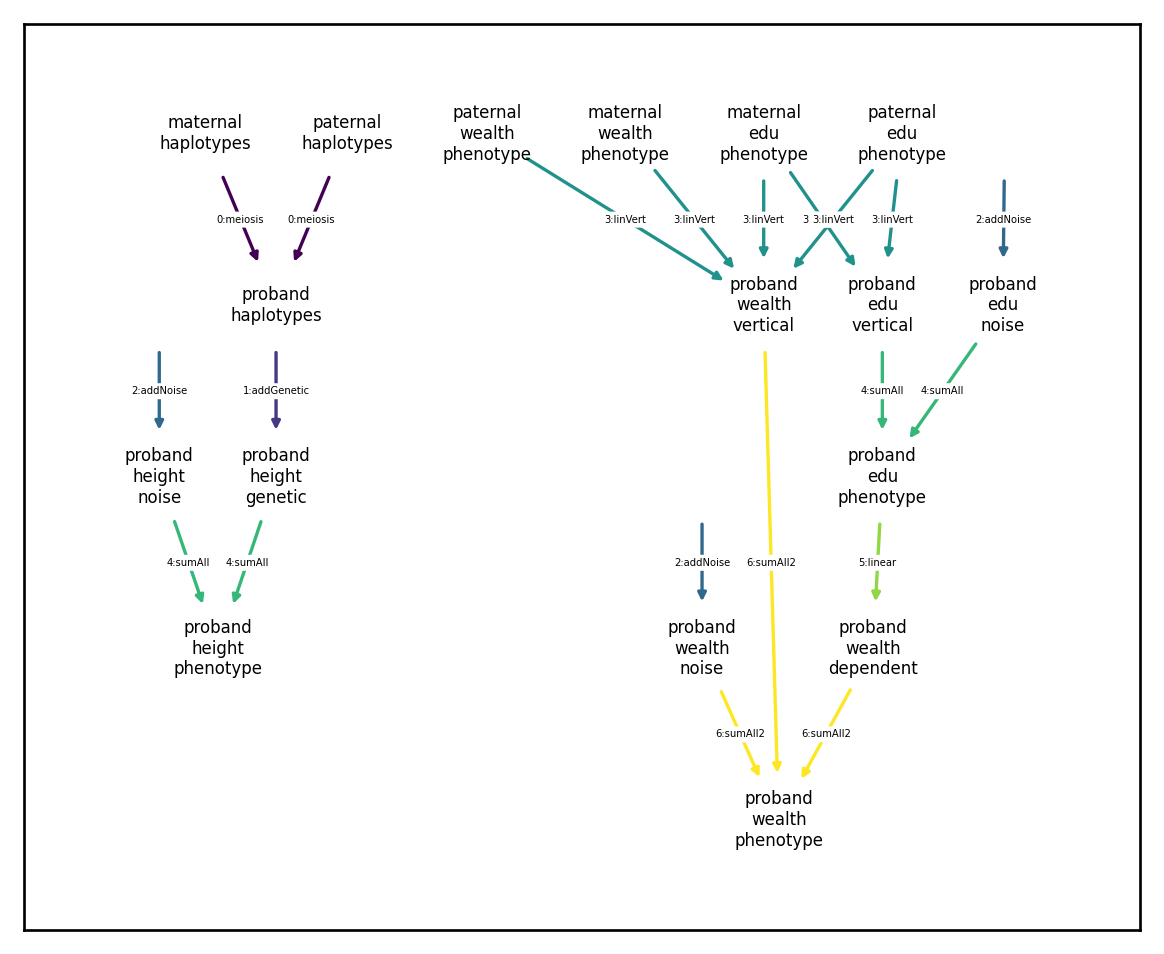

In [42]:
input_cindex=xft.index.ComponentIndex(['wealth', 'wealth','wealth'], 
                                      ['noise', 'vertical','dependent'])

strans_redux3 = xft.arch.SumAllTransformation(input_cindex,
                                              component_name='sumAll2')
                                                                                                                                                                
                                                                   
arch_redux3 = xft.arch.Architecture([genetic_comp,
                                     noise_comp,
                                     vt_comp,
                                     strans_redux1,
                                     causal_comp,
                                     strans_redux3])
arch_redux3.draw_dependency_graph(font_size=5, node_size=800, arrowsize=5)